In [1]:
import numpy as np
import pandas as pd
import scipy.linalg

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.transforms as transforms
import matplotlib as mpl
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 8}

plt.rc('font', **font)
width  = 3.402
height = width / 1.2

import sys
print(sys.version)
sys.path.append('../')
import time

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.learning.blr_slip import SlipBayesianLinearRegression, FullBodySlipBayesianLinearRegression
from models.learning.blr_slip_acceleration import SlipAccelerationBayesianLinearRegression, FullBodySlipAccelerationBayesianLinearRegression
from models.learning.blr_acceleration import AccelerationBayesianLinearRegression, FullBodyAccelerationBayesianLinearRegression
from models.learning.gp_slip import *
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *


from util.transform_algebra import *
from util.util_func import *

from sklearn import linear_model

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [4]:
# import all slip datasets

train_datasets = []
validate_datasets = []

dataset_paths = [] 
dataset_labels = []
dataset_paths.append('../data/ral2023_dataset/husky/boreal_snow/acceleration_dataset.pkl')
dataset_labels.append(r'Hu_snow')
dataset_paths.append('../data/ral2023_dataset/husky/grand_salon_tile_inflated/acceleration_dataset.pkl')
dataset_labels.append(r'Hu_tile')
# dataset_paths.append('../data/ral2023_dataset/husky/grand_salon_left-deflated/acceleration_dataset.pkl')
# dataset_labels.append('H_tile_ld')
dataset_paths.append('../data/ral2023_dataset/marmotte/boreal_snow/acceleration_dataset.pkl')
dataset_labels.append(r'HD2_snow')
        # dataset_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_a/acceleration_dataset.pkl')
        # dataset_labels.append('M_hard_snow_a')
dataset_paths.append('../data/ral2023_dataset/marmotte/grand_salon_tile_b/acceleration_dataset.pkl')
dataset_labels.append(r'HD2_tile')
# dataset_paths.append('../data/ral2023_dataset/marmotte/ga_hard_snow_b/acceleration_dataset.pkl')
# dataset_labels.append('M_hard_snow')
# dataset_paths.append('../data/ral2023_dataset/warthog_tracks/boreal_mud/acceleration_dataset.pkl')
# dataset_labels.append(r'Wt_mud')
# dataset_paths.append('../data/ral2023_dataset/warthog_tracks/grand-axe_crusted-snow/acceleration_dataset.pkl')
# dataset_labels.append('Wt_crust')
dataset_paths.append('../data/ral2023_dataset/warthog_wheels/gravel_1/acceleration_dataset.pkl')
dataset_labels.append(r'Ww_gravel')
dataset_paths.append('../data/ral2023_dataset/warthog_wheels/ice/acceleration_dataset.pkl')
dataset_labels.append(r'Ww_ice')

for dataset_path in dataset_paths:
    full_dataset = pd.read_pickle(dataset_path)
    full_dataset_length = len(full_dataset)
    train_dataset = full_dataset[:int(full_dataset_length/2)]
    train_datasets.append(train_dataset)
    validate_dataset = full_dataset[int(full_dataset_length/2):]
    validate_datasets.append(validate_dataset)
    print(dataset_path)

../data/ral2023_dataset/husky/boreal_snow/acceleration_dataset.pkl
../data/ral2023_dataset/husky/grand_salon_tile_inflated/acceleration_dataset.pkl
../data/ral2023_dataset/marmotte/boreal_snow/acceleration_dataset.pkl
../data/ral2023_dataset/marmotte/grand_salon_tile_b/acceleration_dataset.pkl
../data/ral2023_dataset/warthog_wheels/gravel_1/acceleration_dataset.pkl
../data/ral2023_dataset/warthog_wheels/ice/acceleration_dataset.pkl


In [7]:
# extract body_vel_distruptions arrays (output arrays)

str_body_vel_disturption_x_list = []
str_body_vel_disturption_y_list = []
str_body_vel_disturption_yaw_list = []
for i in range(0, 40):
    str_body_vel_disturption_x_i = 'body_vel_disturption_x_' + str(i)
    str_body_vel_disturption_y_i = 'body_vel_disturption_y_' + str(i)
    str_body_vel_disturption_yaw_i = 'body_vel_disturption_yaw_' + str(i)
    str_body_vel_disturption_x_list.append(str_body_vel_disturption_x_i)
    str_body_vel_disturption_y_list.append(str_body_vel_disturption_y_i)
    str_body_vel_disturption_yaw_list.append(str_body_vel_disturption_yaw_i)
    
# body_vel_disturption_x_array = full_dataset[str_body_vel_disturption_x_list].to_numpy()
# body_vel_disturption_y_array = full_dataset[str_body_vel_disturption_y_list].to_numpy()
# body_vel_disturption_yaw_array = full_dataset[str_body_vel_disturption_yaw_list].to_numpy()

In [14]:
# compute body vel disruptions modulus
body_vel_disturption_modulus_list = []
for i in range(0, len(dataset_paths)):
    full_dataset = pd.read_pickle(dataset_paths[i])
    body_vel_disturption_x_array = full_dataset[str_body_vel_disturption_x_list].to_numpy()
    body_vel_disturption_y_array = full_dataset[str_body_vel_disturption_y_list].to_numpy()
    body_vel_disturption_yaw_array = full_dataset[str_body_vel_disturption_yaw_list].to_numpy()
    body_vel_disturption_modulus_array = np.zeros(body_vel_disturption_x_array.shape[0])
    for j in range(0, len(full_dataset)):
        body_vel_disturption_j = np.array([body_vel_disturption_x_array[j], 
                                           body_vel_disturption_y_array[j], 
                                           body_vel_disturption_yaw_array[j]])
        body_vel_disturption_modulus_array[j] = np.linalg.norm(body_vel_disturption_j)
    body_vel_disturption_modulus_list.append(body_vel_disturption_modulus_array)
        

/tmp/ipykernel_26527/894288666.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_plasma = mpl.cm.get_cmap('plasma')
/tmp/ipykernel_26527/894288666.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_viridis = mpl.cm.get_cmap('viridis')


['Hu_snow', 'Hu_tile', 'HD2_snow', 'HD2_tile', 'Ww_gravel', 'Ww_ice']


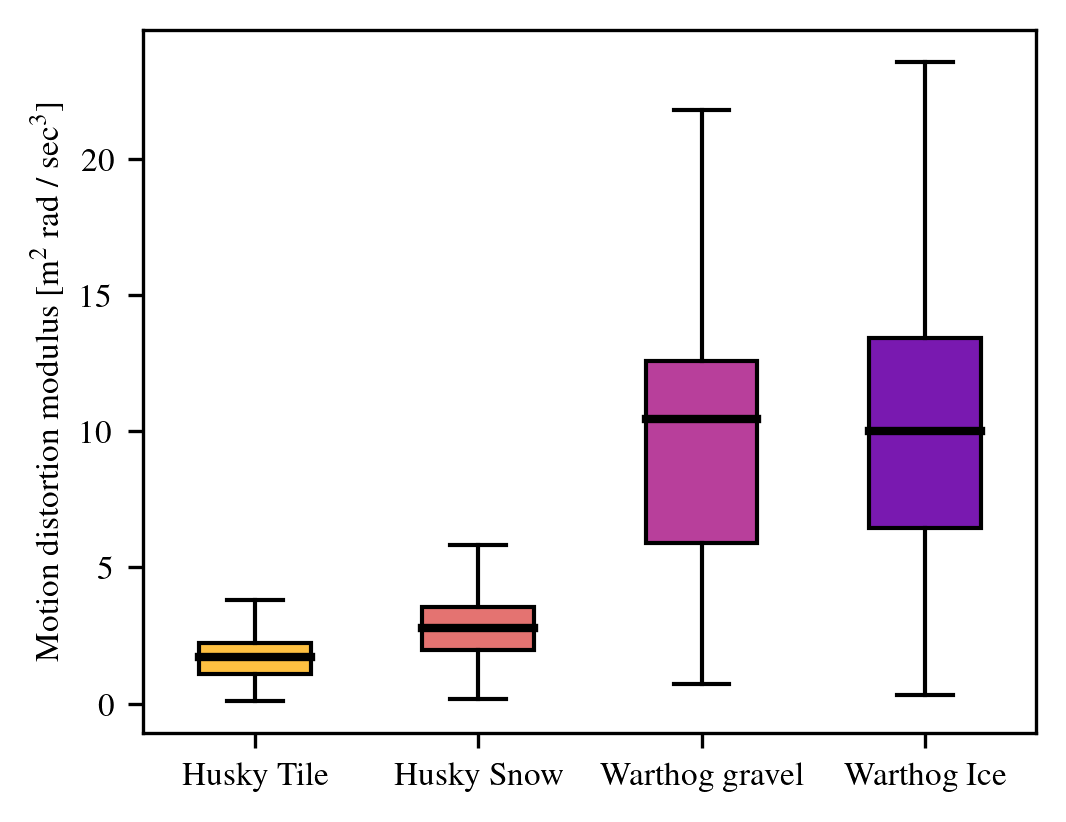

In [45]:
from matplotlib.patches import Patch

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
mpl.rcParams['lines.dashed_pattern'] = [2, 2]

fig, ax = plt.subplots(1, dpi=300, gridspec_kw={'hspace': 0.1, 'wspace': 0.0}, sharex=True)
fig.set_size_inches(width, height/1.1)
fig.subplots_adjust(left=.12, bottom=0.08, right=.995, top=.99)

medians_color = 'k'
medians_width = 0.8
boxplots_width = 0.5

cmap_alpha = 0.9
cmap_alpha_darker = 0.99
cmap_plasma = mpl.cm.get_cmap('plasma')
cmap_viridis = mpl.cm.get_cmap('viridis')

cmd_box_color = cmap_plasma(0.85)                                                        # naive
cmd_box_color_list = list(cmd_box_color)
cmd_box_color_list[3] = cmap_alpha
cmd_box_color = tuple(cmd_box_color_list)

husky_tile_box_color = cmap_plasma(0.85)                                                        # naive
husky_tile_box_color_list = list(husky_tile_box_color)
husky_tile_box_color_list[3] = cmap_alpha
husky_tile_box_color = tuple(husky_tile_box_color_list)

husky_snow_box_color = cmap_plasma(0.6)                                                   # husky_snow
husky_snow_box_color_list = list(husky_snow_box_color)
husky_snow_box_color_list[3] = cmap_alpha
husky_snow_box_color = tuple(husky_snow_box_color_list)

warthog_gravel_box_color = cmap_plasma(0.4)                                                   # warthog_gravel
warthog_gravel_box_color_list = list(warthog_gravel_box_color)
warthog_gravel_box_color_list[3] = cmap_alpha
warthog_gravel_box_color = tuple(warthog_gravel_box_color_list)

warthog_ice_box_color = cmap_plasma(0.2)                                                   # warthog_ice
warthog_ice_box_color_list = list(warthog_ice_box_color)
warthog_ice_box_color_list[3] = cmap_alpha
warthog_ice_box_color = tuple(warthog_ice_box_color_list)

figure_datasets = [1, 0, 4, 5]
position_iterator = 0
print(dataset_labels)

plt.boxplot(body_vel_disturption_modulus_list[1], positions=[0], showfliers=False, widths=boxplots_width, 
            patch_artist=True,
               boxprops=dict(facecolor = husky_tile_box_color, color = 'k'),
               whiskerprops=dict(color='k'),
               medianprops=dict(color=medians_color, linewidth=2))

plt.boxplot(body_vel_disturption_modulus_list[0], positions=[1], showfliers=False, widths=boxplots_width, 
            patch_artist=True,
               boxprops=dict(facecolor = husky_snow_box_color, color = 'k'),
               whiskerprops=dict(color='k'),
               medianprops=dict(color=medians_color, linewidth=2))

plt.boxplot(body_vel_disturption_modulus_list[4], positions=[2], showfliers=False, widths=boxplots_width, 
            patch_artist=True,
               boxprops=dict(facecolor = warthog_gravel_box_color, color = 'k'),
               whiskerprops=dict(color='k'),
               medianprops=dict(color=medians_color, linewidth=2))

plt.boxplot(body_vel_disturption_modulus_list[5], positions=[3], showfliers=False, widths=boxplots_width, 
            patch_artist=True,
               boxprops=dict(facecolor = warthog_ice_box_color, color = 'k'),
               whiskerprops=dict(color='k'),
               medianprops=dict(color=medians_color, linewidth=2))

xticks = [0, 1, 2, 3]
ax.set_xticks(xticks)
ax.set_xticklabels(['Husky Tile', 'Husky Snow', 'Warthog gravel', 'Warthog Ice'])

ax.set_ylabel('Motion distortion modulus [m$^2$ rad / sec$^3$]')

plt.savefig('figs/slip_norms.pdf')
plt.savefig('figs/slip_norms.jpg', dpi=500)